In [1]:
%matplotlib inline

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pylab
import seaborn as sns

## Helper Functions and Plots

In [2]:
def loadCompsData(compsCSV):
    data = pd.read_csv(compsCSV)
    for col in data.columns:
        if 'date' in col.lower():
            data[col] = pd.to_datetime(data[col], format='%m/%d/%Y')
    
    return data

def loadFundingData(fundingCSV):
    data = pd.read_csv(fundingCSV)
    data = data.drop_duplicates()
    data['Date'] = pd.to_datetime(data['Announced On Date'])
    data.drop('Announced On Date', axis=1, inplace=True)
    data.sort_values('Date', inplace=True)
    data['Year'] = [ date.year for date in data['Date'] ]
    data.dropna(subset=['Money Raised'], inplace=True)
    
    #Parse different currency types
    trim = re.compile(r'[^\d.]+')
    for i in data.index:
        # Yes, these exchange rates should ideally be pulled from a database
        # based on when the deal happened. But, these are also VC valuations
        # which likely have more variation and error in them than the
        # currency fluctuations
        if '$' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = float(trim.sub('', data.loc[i, 'Money Raised']))
        elif '€' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 1.2*float(trim.sub('', data.loc[i, 'Money Raised']))
        elif '£' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 1.4*float(trim.sub('', data.loc[i, 'Money Raised']))
        elif '¥' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 0.01*float(trim.sub('', data.loc[i, 'Money Raised']))
        elif '₹' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 0.0175*float(trim.sub('', data.loc[i, 'Money Raised']))
        elif 'ман' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 0.75*float(trim.sub('', data.loc[i, 'Money Raised']))
        elif 'kr' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 0.11*float(trim.sub('', data.loc[i, 'Money Raised']))
        elif 'CHF' in data.loc[i, 'Money Raised']:
            data.loc[i, 'Amount'] = 0.99*float(trim.sub('', data.loc[i, 'Money Raised']))
        else:
            print data.loc[i, 'Money Raised']
            raise ValueError
    
    data['Amount'] = [ float(trim.sub('', value)) for value in data['Money Raised'] ]
    data['Amount'] = data['Amount']*1.0e-6
    data.drop('Money Raised', axis=1, inplace=True)
    data['Total Investment'] = data['Amount'].cumsum()
        
    return data

def calculateBurnRate(data):
    dfs = []
    comps = list(set(data['Comparable Name']))
    
    for comp in comps:
        compData = data.loc[data['Comparable Name'] == comp].copy()
        if len(compData) > 1:
            compData.sort_values('Date', inplace=True)
            compData['Time Until Next Round'] = (compData['Date'].shift(-1) - compData['Date']).dt.days/30.4167
            compData['Burn Rate'] = 1000.0*compData['Amount']/compData['Time Until Next Round']
            dfs.append(compData)
        else:
            compData['Time Until Next Round'] = np.nan
            compData['Burn Rate'] = np.nan
            dfs.append(compData)
                
    return pd.concat(dfs)

def loadCompanyData(directory):
    dfs = []
    
    for co in os.listdir(directory):
        if '.' not in co:
            files = os.listdir('./' + co)
            for fileName in files:
                if ('funding' in fileName) and (fileName.split('.')[-1] == 'csv'):
                    data = loadFundingData('./' + co + '/' + fileName)
                    data.rename(columns={'Company Name':'Comparable Name', 
                                         'Company Name URL':'Comparable Name URL'}, 
                                inplace=True)
                    data['Company'] = co
                    dfs.append(calculateBurnRate(data))
                    
    df = pd.concat(dfs)
    return df

def getGroupStats(data):
    summary = {}
    summary['Med Num Cos'] = np.median(data.groupby('Company').count()['Date'])
    
    seedRounds = data.loc[data['Funding Type'] == 'Seed']
    summary['Med Seed Size'] = seedRounds['Amount'].median()*1000.0
    
    burnRates = seedRounds.loc[seedRounds['Burn Rate'] != np.inf]
    summary['Med Burn Rate'] = burnRates['Burn Rate'].median()
    
    return summary

def orderFundingTypes(fundingTypes):   
    targetOrder = ['Grant', 'Seed', 'Angel', 'Equity Crowdfunding', 
                   'Series', 'Convertible Note', 'Debt Financing']
    fundingOrdered = []
    
    for i in range(len(targetOrder)):
        if targetOrder[i] in fundingTypes:
            fundingOrdered.append(targetOrder[i])
        elif targetOrder[i] == 'Series':
            seriesFunding = [ fundingType for fundingType in fundingTypes if 'series' in fundingType.lower() ]
            seriesFunding.sort()
            fundingOrdered.extend(seriesFunding)
    
    return fundingOrdered

def fundingTypePlot(data, savefig=False, filename=None, closefig=False, earlyStageOnly=False):
    if earlyStageOnly:
        typesToKeep = ['Grant', 'Seed', 'Angel', 'Equity Crowdfunding', 'Convertible Note']
        selector = [ fundingType in typesToKeep for fundingType in data['Funding Type'] ]
        dataToPlot = data.loc[selector]
    else:
        dataToPlot = data
    
    labels = orderFundingTypes(set(dataToPlot['Funding Type']))
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,2.5))
    
    sns.barplot(data=dataToPlot, x='Amount', y='Funding Type', order=labels, 
                estimator=np.median, ci=None, ax=ax1, palette='Blues_d')
    ax1.set_title('Investment by Funding Type')
    ax1.set_xlabel('Median Investment (MM of USD)')
    
    sns.barplot(data=dataToPlot, x='Amount', y='Funding Type', order=labels, 
                estimator=np.sum, ci=None, ax=ax2, palette='Greens_d')
    ax2.set_title('Cumulative Investment by Funding Type')
    ax2.set_xlabel('Total Investment (MM of USD)')
    ax2.set_ylabel('')
    ax2.set_yticklabels([])
    
    if savefig:
        try:
            fig.savefig(filename, dpi=120, bbox_inches='tight')
        except:
            print "Invalid filename, could not save figure!"
            raise ValueError
            
    if closefig:
        plt.close()
        
    return

def fundingTimingPlot(data, savefig=False, filename=None, closefig=False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,2.5))
    
    sns.barplot(data=data, x='Year', y='Amount', estimator=np.sum, ci=None, ax=ax1, palette="Blues_d")
    ax1.set_title('Yearly Investment')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Investment (MM of USD)')
    
    sns.barplot(data=data, x='Year', y='Total Investment', estimator=np.max, ci=None, ax=ax2, palette="Greens_d")
    ax2.set_title('Cumulative Investment To Date')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Investment (MM of USD)')
    
    if savefig:
        try:
            fig.savefig(filename, dpi=120, bbox_inches='tight')
        except:
            print "Invalid filename, could not save figure!"
            raise ValueError
            
    if closefig:
        plt.close()
        
    return
    
def timingBurnRatePlot(data, savefig=False, filename=False, closefig=False, earlyStageOnly=False):
    if earlyStageOnly:
        typesToKeep = ['Grant', 'Seed', 'Angel', 'Equity Crowdfunding', 'Convertible Note']
        selector = [ fundingType in typesToKeep for fundingType in data['Funding Type'] ]
        dataToPlot = data.loc[selector]
    else:
        dataToPlot = data
        
    # Very few of the companies, < 10, had rouns with the same date
    # which lead to a burn rate of infinity, ignore these
    dataToPlot = dataToPlot.loc[dataToPlot['Burn Rate'] != np.inf]
    
    labels = orderFundingTypes(set(dataToPlot['Funding Type']))
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,2.5))
    
    sns.barplot(data=dataToPlot, x='Time Until Next Round', y='Funding Type', order=labels, 
                estimator=np.median, ci=None, ax=ax1, palette='Blues_d')
    ax1.set_title('Round Timing')
    ax1.set_xlabel('Median Time Between Funding Rounds (Months)')
    
    sns.barplot(data=dataToPlot, x='Burn Rate', y='Funding Type', order=labels, 
                estimator=np.median, ci=None, ax=ax2, palette='Greens_d')
    ax2.set_title('Burn Rate by Funding Type')
    ax2.set_xlabel('Median Burn Rate (Thousands of USD per Month)')
    ax2.set_ylabel('')
    ax2.set_yticklabels([])
    
    if savefig:
        try:
            fig.savefig(filename, dpi=120, bbox_inches='tight')
        except:
            print "Invalid filename, could not save figure!"
            raise ValueError
            
    if closefig:
        plt.close()
        
def megaPlot(data, savefig=False, filename=None, closefig=False, earlyStageOnly=False):
    if earlyStageOnly:
        typesToKeep = ['Grant', 'Seed', 'Angel', 'Equity Crowdfunding', 'Convertible Note']
        selector = [ fundingType in typesToKeep for fundingType in data['Funding Type'] ]
        dataToPlot = data.loc[selector]
    else:
        dataToPlot = data
    
    labels = orderFundingTypes(set(dataToPlot['Funding Type']))
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(12,7.5))
    
    sns.barplot(data=data, x='Year', y='Amount', estimator=np.sum, ci=None, ax=ax1, palette="Blues_d")
    ax1.set_title('Yearly Investment')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Investment (MM of USD)')
    
    sns.barplot(data=data, x='Year', y='Total Investment', estimator=np.max, ci=None, ax=ax2, palette="Greens_d")
    ax2.set_title('Cumulative Investment To Date')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Investment (MM of USD)')
    
    sns.barplot(data=dataToPlot, x='Amount', y='Funding Type', order=labels, 
                estimator=np.median, ci=None, ax=ax3, palette='Blues_d')
    ax3.set_title('Investment by Funding Type')
    ax3.set_xlabel('Median Investment (MM of USD)')
    
    sns.barplot(data=dataToPlot, x='Amount', y='Funding Type', order=labels, 
                estimator=np.sum, ci=None, ax=ax4, palette='Greens_d')
    ax4.set_title('Cumulative Investment by Funding Type')
    ax4.set_xlabel('Total Investment (MM of USD)')
    ax4.set_ylabel('')
    ax4.set_yticklabels([])
    
    sns.barplot(data=dataToPlot, x='Time Until Next Round', y='Funding Type', order=labels, 
                estimator=np.median, ci=None, ax=ax5, palette='Blues_d')
    ax5.set_title('Round Timing')
    ax5.set_xlabel('Median Time Between Funding Rounds (Months)')
    
    sns.barplot(data=dataToPlot, x='Burn Rate', y='Funding Type', order=labels, 
                estimator=np.median, ci=None, ax=ax6, palette='Greens_d')
    ax6.set_title('Burn Rate by Funding Type')
    ax6.set_xlabel('Median Burn Rate (Thousands of USD per Month)')
    ax6.set_ylabel('')
    ax6.set_yticklabels([])
    
    plt.tight_layout()
    
    if savefig:
        try:
            fig.savefig(filename, dpi=120, bbox_inches='tight')
        except:
            print "Invalid filename, could not save figure!"
            raise ValueError
            
    if closefig:
        plt.close()
        
    return
        

def comparisonPlot(companyName, groupData, savefig=False, filename=False, closefig=False):
    maxBubbleSize = 50
    offset = 0.35*maxBubbleSize*2
    groupColor = '#4984AE'
    companyColor = '#45925A'
    groupStats = getGroupStats(groupData)
    companyStats = getGroupStats(groupData.loc[groupData['Company'] == companyName])
    
    x = []
    rawValues = []
    s = []
    c = []
    baseSpacing = [0, maxBubbleSize*4, maxBubbleSize*8]
    

    for key, spacing in zip(['Med Num Cos', 'Med Seed Size', 'Med Burn Rate'], baseSpacing):
        x.extend([spacing - offset, spacing + offset])
        values = np.sqrt(np.array([groupStats[key], companyStats[key]]))
        rawValues.extend(np.array([groupStats[key], companyStats[key]]))
        sizing = values*maxBubbleSize/values.max()
        s.extend(sizing)
        c.extend([groupColor,companyColor])
        
    fig = pylab.figure(figsize=(12,2.5))
    ax=pylab.axes()
        
    for i in range(len(x)):
        #Check whether we have any bad data
        if i % 2 == 0:
            if np.isnan(rawValues[i+1]):
                doNotPlot = True
            else:
                doNotPlot = False
        else:
            if np.isnan(rawValues[i]):
                doNotPlot = True
            else:
                doNotPlot = False
        
        #Format text
        if doNotPlot:
            pass
        elif i <2:
            doNotPlot = False
            text = '%.f' % rawValues[i]
        elif i >= 2 and i < 4:
            doNotPlot = False
            text = '$%.fK' % rawValues[i]
        else:
            doNotPlot = False
            text = '$%.fK' % rawValues[i]
        
        #Create bubble chart
        if not doNotPlot:
            circle = pylab.Circle((x[i], 0.0), radius=s[i], color=c[i])
            ax.add_patch(circle)
            ax.text(x[i] - 0.75*s[i], -2.5, text, fontsize=14, color='white')
        elif i % 2 != 0:
            circle = pylab.Circle((x[i], 0.0), radius=0, color=c[i])
            ax.add_patch(circle)
            text = 'Not Enough Data'
            ax.text(baseSpacing[(i-1)/2]-47.5, -2.5, text, fontsize=14, color='Black')
        
    plt.grid(False)
    ax.set_axis_bgcolor('white')
    ax.set_xticks(baseSpacing)
    ax.set_xticklabels(['Median Companies in Space', 'Median Seed Size', 'Median Seed Montly Burn Rate'])
    ax.set_yticklabels([])
    groupPatch = mpatches.Patch(color=groupColor, label='All ES/FIN 329/629 Companies')
    companyPatch = mpatches.Patch(color=companyColor, label=companyName)
    plt.legend(handles=[groupPatch, companyPatch], loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
        
    pylab.axis('scaled')
    
    if savefig:
        try:
            fig.savefig(filename, dpi=120, bbox_inches='tight')
        except:
            print "Invalid filename, could not save figure!"
            raise ValueError
            
    if closefig:
        pylab.close()
    


## Load Data For All ES/FIN 329/629 Companies

In [3]:
compDataset = loadCompanyData('.')

### Plot Metrics for Entire Dataset

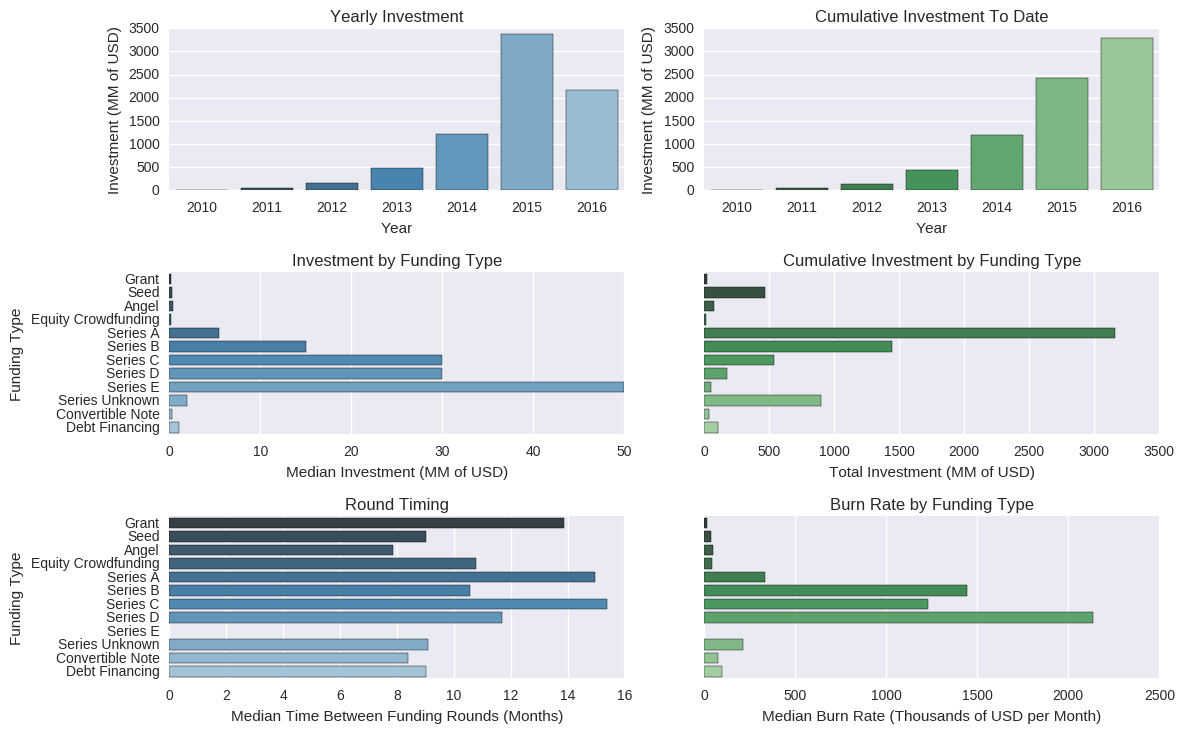

In [6]:
megaPlot(compDataset, True, 'all_companies.png')

### Create Plots for Each Company

In [5]:
companies = compDataset['Company'].unique()

for company in companies:
    plotRootName = os.path.join('.', company, company)
    data = compDataset.loc[compDataset['Company'] == company]
    comparisonPlot(company, compDataset, True, plotRootName + '-high_level.png', True)
    fundingTimingPlot(data, True, plotRootName + '-timing.png', True)
    fundingTypePlot(data, True, plotRootName + '-type.png', True, True)
    timingBurnRatePlot(data, True, plotRootName + '-burn.png', True, True)
    megaPlot(data, True, plotRootName + '-mega.png', True, True)